# Opening Remarks

This Notebook was prepared for fun under time constrains. This focus more on preparing the dataset , feature engineer and feature selection.

It does not contain spliting the datset for tuning hyperparm , no one hot encoder and other important methodology when training model.

I will give my key insights at the begining of each section and explain my thoght process.


#Imports




In [1]:
!pip install openpyxl
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.3.1  #Required for xgboost
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import numpy as np
from google.colab import files
import os
import seaborn as sns
import itertools
import xgboost as xgb
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns




Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 90.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.3.1 which is incompatible.


#Load Data

Upload from PC

In [2]:
# Prompt the user to choose the file type
print("Choose the file type to upload (csv/excel): ")

# Upload the file
uploaded = files.upload()
# Get the uploaded file name
file_name = list(uploaded.keys())[0]


Choose the file type to upload (csv/excel): 


Saving train_dataset_full.csv to train_dataset_full.csv


Upload from the colab dir

In [2]:
# List all files in /content directory
files = os.listdir('/content/')
print("Files in /content:", files)

Files in /content: ['.config', 'X_test_1st.csv', 'train_dataset_full.csv', 'sample_data']


In [5]:
def load_data(file_name):
  # Load the file into a Pandas DataFrame
  if file_name.endswith('.csv'):
      df = pd.read_csv(file_name)
      print("CSV file loaded successfully!")
  elif file_name.endswith(('.xls', '.xlsx')):
      df = pd.read_excel(file_name)
      print("Excel file loaded successfully!")
  else:
      print("Invalid file type. Please choose either 'csv' or 'excel'.")
  return df

In [10]:
file_name = files[2]
df = load_data(file_name)

CSV file loaded successfully!


In [11]:
# Create a summary table for the features
def create_summary_table(df):
    summary = pd.DataFrame({
      'Number of Values': df.count(),
      'Number of NaN': df.isna().sum(),
      'Number of Unique Values (excluding NaN)': df.nunique(dropna=True)
    })
    return summary
create_summary_table(df)

,Number of Values,Number of NaN,Number of Unique Values (excluding NaN)
session_id,384997,4166,366681
DateTime,385054,4109,8588
user_id,385055,4108,133893
product,384989,4174,10
campaign_id,384975,4188,10
webpage_id,385006,4157,9
product_category_1,384962,4201,5
product_category_2,80928,308235,28
user_group_id,369844,19319,13
gender,369839,19324,2


# Clean Dataset
Choose the target column, remove duplicates, remove nan from target

In [12]:
# 📋 Display the columns and ask the user to choose the Target column
print("\nAvailable columns:")
for i, col in enumerate(df.columns):
    print(f"{i + 1}. {col}")

# User selects the target column
target_index = int(input("\nSelect the target column by number: ")) - 1
target_column = df.columns[target_index]
print(f"🎯 Target column selected: {target_column}")

# 🔄 Remove duplicate rows
initial_rows = df.shape[0]
duplicates_count = df.duplicated().sum()
duplicate_percentage = (duplicates_count / initial_rows) * 100

print(f"\n⚠️ Duplicates found: {duplicates_count} ({duplicate_percentage:.2f}% of the data)")
df = df.drop_duplicates()

# 🚫 Remove rows with NaN in the target column
nan_in_target = df[target_column].isna().sum()
nan_percentage = (nan_in_target / df.shape[0]) * 100

print(f"⚠️ Rows with NaN in target column: {nan_in_target} ({nan_percentage:.2f}% of the data)")
df = df.dropna(subset=[target_column])

# 📊 Display the cleaned DataFrame
print(f"\n✅ Data cleaned! Final shape: {df.shape}")
df.head()


Available columns:
1. session_id
2. DateTime
3. user_id
4. product
5. campaign_id
6. webpage_id
7. product_category_1
8. product_category_2
9. user_group_id
10. gender
11. age_level
12. user_depth
13. city_development_index
14. var_1
15. is_click

Select the target column by number: 15
🎯 Target column selected: is_click

⚠️ Duplicates found: 19510 (5.01% of the data)
⚠️ Rows with NaN in target column: 3019 (0.82% of the data)

✅ Data cleaned! Final shape: (366634, 15)


,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click
0,98528.0,2017-07-04 16:42,7716.0,C,405490.0,60305.0,3.0,NaN,3.0,Male,3.0,3.0,NaN,1.0,1.0
1,589714.0,2017-07-07 07:40,1035283.0,I,118601.0,28529.0,4.0,82527.0,10.0,Female,4.0,3.0,3.0,1.0,0.0
2,478652.0,2017-07-07 20:42,65994.0,H,359520.0,13787.0,4.0,NaN,4.0,Male,4.0,3.0,2.0,0.0,0.0
3,34536.0,2017-07-05 15:05,75976.0,H,405490.0,60305.0,3.0,NaN,3.0,Male,3.0,3.0,3.0,0.0,0.0
4,71863.0,2017-07-06 20:11,987498.0,C,405490.0,60305.0,3.0,NaN,2.0,Male,2.0,3.0,2.0,0.0,0.0


In [13]:
create_summary_table(df)

,Number of Values,Number of NaN,Number of Unique Values (excluding NaN)
session_id,365349,1285,365349
DateTime,365372,1262,8586
user_id,365406,1228,133645
product,365376,1258,10
campaign_id,365349,1285,10
webpage_id,365370,1264,9
product_category_1,365405,1229,5
product_category_2,76773,289861,28
user_group_id,351011,15623,13
gender,350995,15639,2


#Check the test set to see what we can drop

Why is this important ?

In the training DB there are many features with nans some of those features are not logical in a real world dataset.

In [8]:
df_test = pd.read_csv('/content/X_test_1st.csv')
# Create a summary table for the features
create_summary_table(df_test)

,Number of Values,Number of NaN,Number of Unique Values (excluding NaN)
session_id,60228,0,60228
DateTime,60228,0,7820
user_id,60228,0,41600
product,60228,0,10
campaign_id,60228,0,10
webpage_id,60228,0,9
product_category_1,60228,0,5
product_category_2,12786,47442,18
user_group_id,57825,2403,13
gender,57825,2403,2


So as you can see Session_id , DateTime, User_id...,product_category_1, doesn't have nan in the test set yet it does in the training set, logicaly this values should not have nan since they originate from the webpage, so we can remove those values to clean our training set.

In [15]:
# 📋 Display available columns
print("\nAvailable columns:")
for i, col in enumerate(df.columns):
    print(f"{i + 1}. {col}")

# 🔢 User selects multiple columns (e.g., 1,3,5)
selected_columns = input("\nEnter the column numbers to drop rows with NaN (comma-separated): ")
selected_indices = [int(x.strip()) - 1 for x in selected_columns.split(',')]
columns_to_check = [df.columns[i] for i in selected_indices]

print(f"\n📊 Selected columns: {columns_to_check}")

# 🚫 Drop rows with NaN in any of the selected columns
initial_rows = df.shape[0]
df_cleaned = df.dropna(subset=columns_to_check)
dropped_rows = initial_rows - df_cleaned.shape[0]
dropped_percentage = (dropped_rows / initial_rows) * 100

# ✅ Display results
print(f"\n✅ Dropped {dropped_rows} rows ({dropped_percentage:.2f}%) with NaN in selected columns.")
print(f"Final dataset shape: {df_cleaned.shape}")

# Display the first few rows of the cleaned DataFrame
create_summary_table(df_cleaned)


Available columns:
1. session_id
2. DateTime
3. user_id
4. product
5. campaign_id
6. webpage_id
7. product_category_1
8. product_category_2
9. user_group_id
10. gender
11. age_level
12. user_depth
13. city_development_index
14. var_1
15. is_click

Enter the column numbers to drop rows with NaN (comma-separated): 1,2,3,4,5,6,7,14

📊 Selected columns: ['session_id', 'DateTime', 'user_id', 'product', 'campaign_id', 'webpage_id', 'product_category_1', 'var_1']

✅ Dropped 3097 rows (0.84%) with NaN in selected columns.
Final dataset shape: (363537, 15)


,Number of Values,Number of NaN,Number of Unique Values (excluding NaN)
session_id,363537,0,363537
DateTime,363537,0,8584
user_id,363537,0,133286
product,363537,0,10
campaign_id,363537,0,10
webpage_id,363537,0,9
product_category_1,363537,0,5
product_category_2,76359,287178,28
user_group_id,349193,14344,13
gender,349181,14356,2


In [14]:
# Find overlapping users between two DataFrames
overlapping_users = set(df['user_id']) & set(df_test['user_id'])

print(f"Number of overlapping users: {len(overlapping_users)}")
print(f"Overlapping Users: {overlapping_users}")


Number of overlapping users: 30958
Overlapping Users: {917509, 917516, 524301, 393230, 1048592, 917521, 524306, 19, 393236, 917530, 524319, 131103, 917538, 917541, 131114, 262191, 917553, 393269, 131126, 1048632, 62, 262208, 786497, 1048643, 67, 393287, 655434, 393296, 131156, 917592, 96, 1048672, 97, 655460, 655467, 1048693, 524416, 262274, 786567, 655502, 524430, 142, 262289, 143, 393365, 917655, 524439, 393375, 917667, 524451, 167, 524464, 181, 524476, 131263, 131271, 655563, 655574, 1048790, 917722, 393438, 262383, 1048816, 655603, 393477, 524550, 393478, 917774, 524561, 1048865, 917801, 262442, 306, 393527, 524605, 131391, 524620, 262476, 786766, 131419, 348, 524650, 1048939, 655722, 393583, 262518, 524663, 262525, 655746, 388, 786822, 524683, 1048975, 524690, 786837, 524697, 413, 1048990, 262564, 131507, 1049018, 524733, 262593, 655819, 393676, 1049040, 1049046, 262619, 131550, 1049062, 524782, 1049075, 499, 262645, 393724, 1049086, 655876, 393737, 786956, 526, 131612, 655904, 91

# Visualize Features

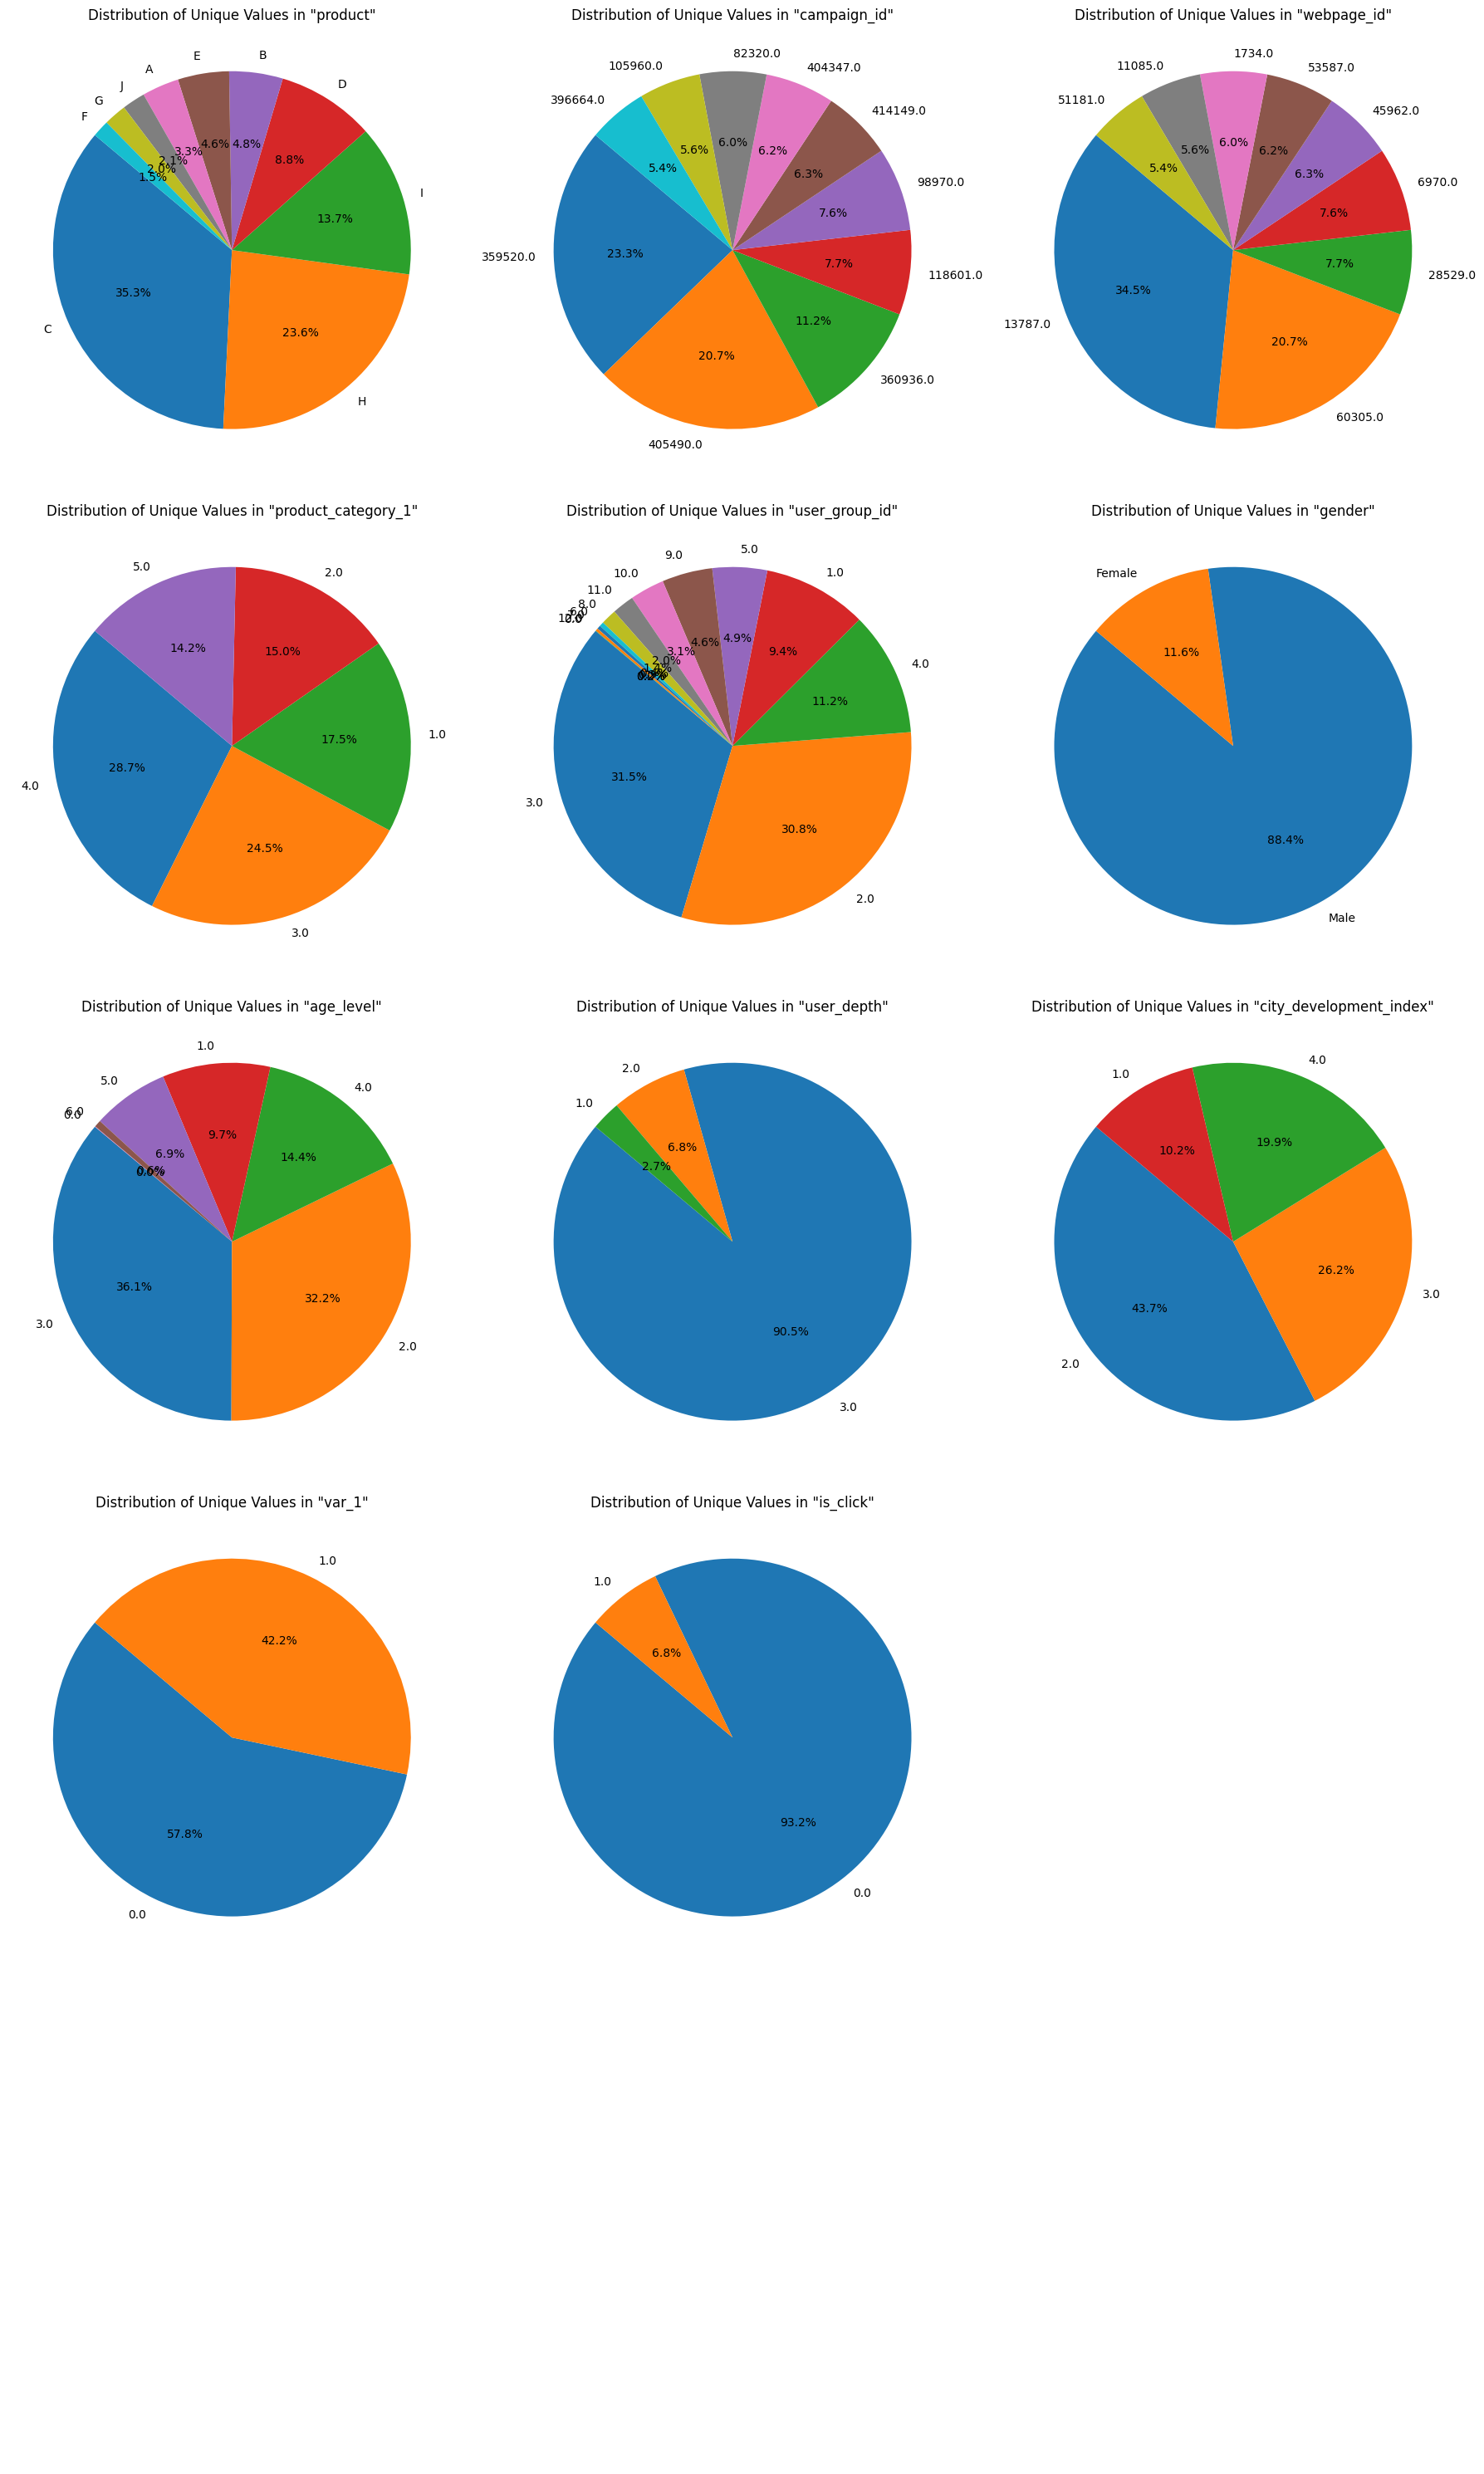

In [14]:
# Determine the number of features to plot
columns = df.columns
num_features = len(columns)

# Define the layout: 3 images per row
num_cols = 3
num_rows = int(np.ceil(num_features / num_cols))

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 6 * num_rows))
axes = axes.flatten()  # Flatten to iterate easily
k = 0  # Counter for features
# Generate pie charts for each feature
for i, column in enumerate(columns):
    value_counts = df[column].value_counts(dropna=True)

    # Plot pie chart if there are fewer than 20 unique values
    if len(value_counts) < 20:
        axes[k].pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
        axes[k].set_title(f'Distribution of Unique Values in "{column}"')
        k += 1
    # else:
    #     axes[i].axis('off')  # Turn off the axis if the feature is skipped

# Turn off empty subplots
for j in range(k , len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


# Visualise Features Connection

This section is mostly exploratory

There are 2 functions interesting yet at the end it does not add a lot to the dataset:

1. analyze_crosstab- check the correletion between 2 or more features this help to present a thumb rul for imputation

2. impute_based_on_rule- imputing the ds using the rule.

Key takeaway this didn't prove to add more data, I did see that the citi index while haveing it , might be important to the is_click

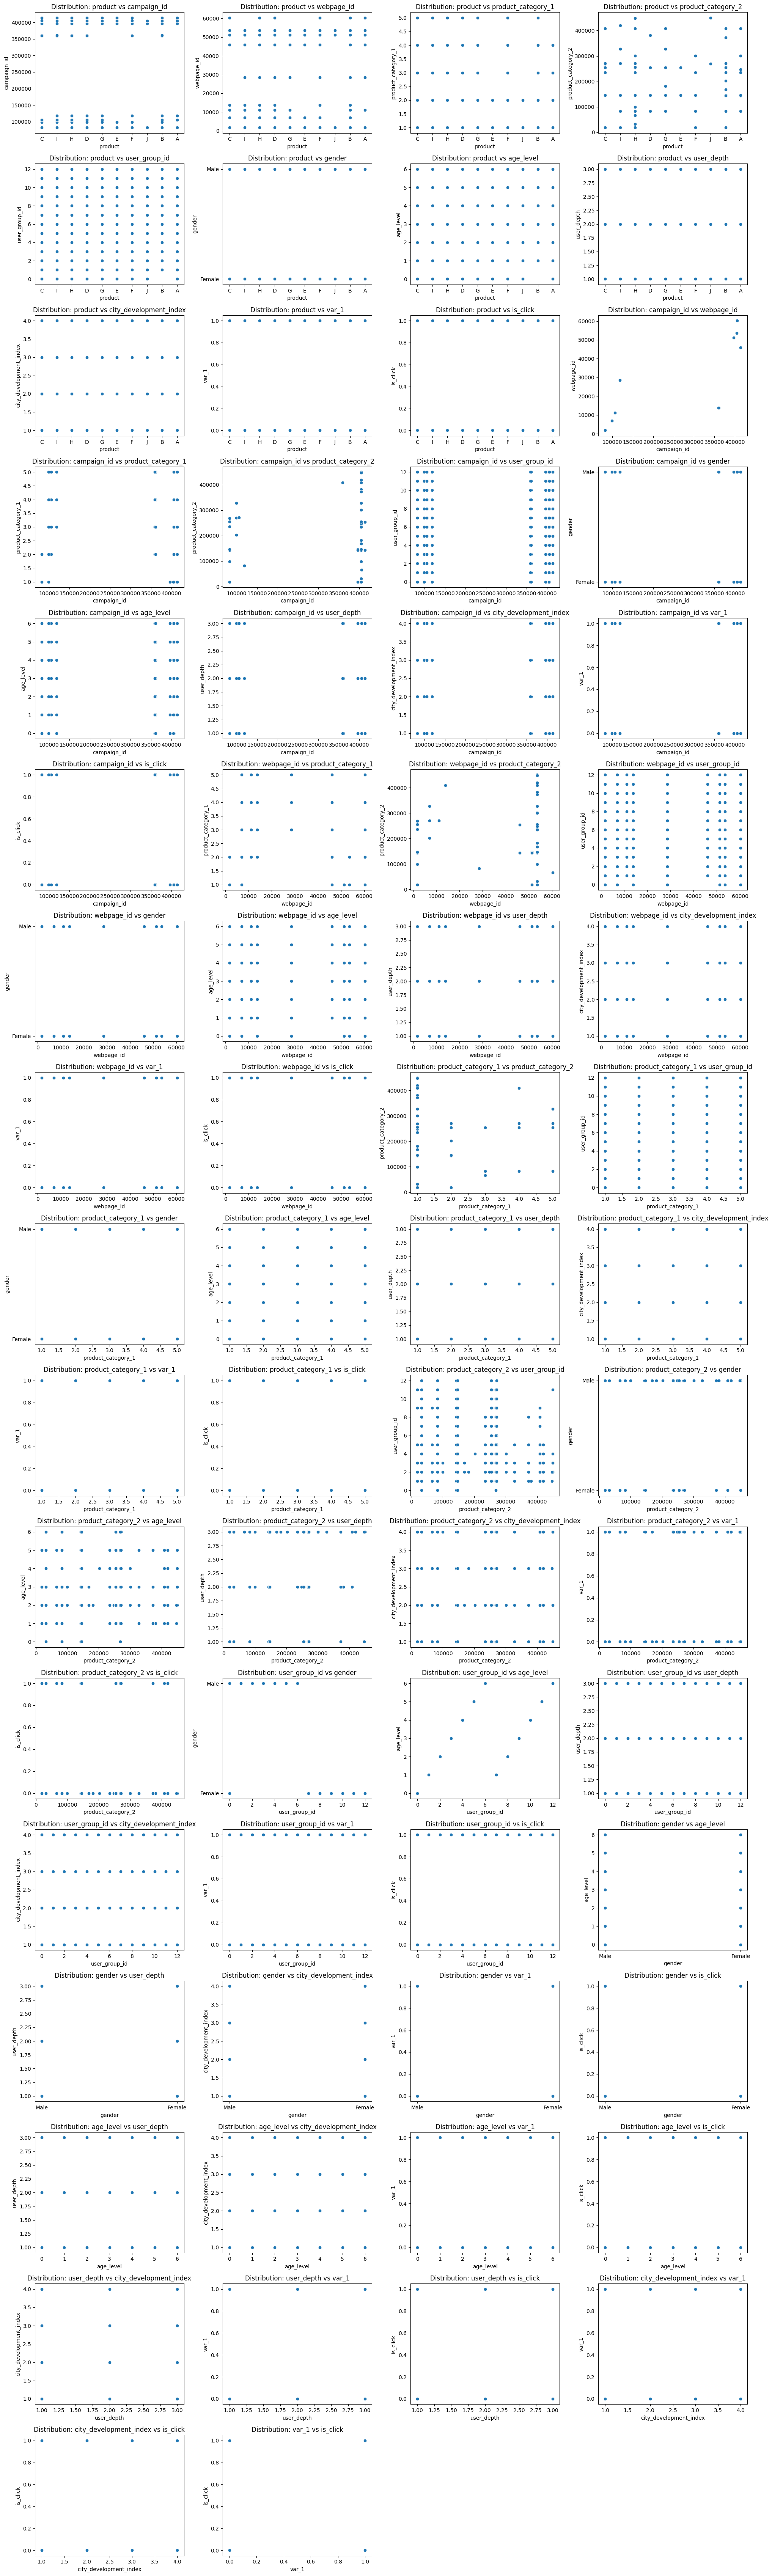

In [10]:
def plot_feature_distributions(df, columns=None, exclude_columns=None, plots_per_row=4):
    """
    Plots the distribution between every pair of features from the given columns.

    Parameters:
    -----------
    df : pd.DataFrame
        The DataFrame containing the data.
    columns : list, optional
        List of columns to plot pairwise distributions. If None, all columns are considered.
    exclude_columns : list, optional
        List of columns to exclude from the pairwise plots.
    plots_per_row : int, optional (default=4)
        Number of plots per row.
    """
    # If no specific columns are provided, use all columns
    if columns is None:
        columns = df.columns.tolist()

    # Exclude specified columns
    if exclude_columns:
        columns = [col for col in columns if col not in exclude_columns]

    # Generate all possible pairs of features
    feature_pairs = list(itertools.combinations(columns, 2))
    num_plots = len(feature_pairs)
    num_rows = -(-num_plots // plots_per_row)  # Ceiling division

    # Set the figure size
    plt.figure(figsize=(5 * plots_per_row, 4 * num_rows))

    # Plot each pair
    for idx, (feature1, feature2) in enumerate(feature_pairs, start=1):
        plt.subplot(num_rows, plots_per_row, idx)
        sns.scatterplot(data=df, x=feature1, y=feature2)
        plt.title(f'Distribution: {feature1} vs {feature2}')

    plt.tight_layout()
    plt.show()


plot_feature_distributions(df_cleaned, columns=df_cleaned.columns.tolist(),exclude_columns=['session_id','DateTime','user_id'], plots_per_row=4)



In [17]:

def analyze_crosstab(crosstab_df, dominance_threshold=0.9):
    """
    Analyzes a crosstab to detect dominant categories for each column.

    Parameters:
    -----------
    crosstab_df : pd.DataFrame
        The crosstab DataFrame with categories as the index and features as columns.
    dominance_threshold : float, optional (default=0.9)
        The minimum proportion required to consider a category as dominant (range: 0-1).

    Returns:
    --------
    dict
        A dictionary where keys are column names and values are the dominant category and its dominance percentage.
    """
    correlation_results = {}

    # Iterate over each feature (columns in the crosstab)
    for col in crosstab_df.columns:
        total = crosstab_df[col].sum()  # Total count for this column

        if total == 0:
            continue  # Skip empty columns

        # Calculate the proportion of each category in the column
        proportions = crosstab_df[col] / total

        # Check if any category dominates above the threshold
        dominant_category = proportions[proportions >= dominance_threshold]

        if not dominant_category.empty:
            correlation_results[col] = {
                'Dominant Category': dominant_category.index[0],
                'Dominance %': dominant_category.values[0] * 100,
                'Dominance #': dominant_category.values[0]* total
            }

    return correlation_results




In [79]:
contingency_table = pd.crosstab(
    index=[df['is_click']],
    columns=[df['user_depth'],df['city_development_index'], df['user_group_id']]
)
contingency_table

user_depth              1.0                                               ...  \
city_development_index  1.0                                2.0            ...   
user_group_id          2.0  3.0  4.0  5.0  8.0  9.0  11.0 1.0  2.0  3.0   ...   
is_click                                                                  ...   
0.0                       7    2    2    1    2    1    1    2   17   24  ...   
1.0                       0    0    0    0    0    0    0    2    1    3  ...   

user_depth                3.0                                                   
city_development_index    4.0                                                   
user_group_id            3.0   4.0   5.0  6.0  7.0  8.0   9.0   10.0 11.0 12.0  
is_click                                                                        
0.0                     16797  5571  1998  183   78  934  3090  1977  790   93  
1.0                      1202   371   187   10   10   62   202   120   75   14  

[2 rows x 134 columns]

In [18]:
def impute_based_on_rule(df, columns, target_column, rule):
    """
    Imputes missing values in the target column based on dominance rules from a contingency table.

    Parameters:
    -----------
    df : pd.DataFrame
        The DataFrame containing the data.
    columns : list
        List of columns used to determine the rule (e.g., ['user_group_id']).
    target_column : str
        The target column where missing values (NaN) will be imputed.
    rule : dict
        A dictionary containing dominance rules, e.g., {1.0: {'Dominant Category': 'Male'}, ...}

    Returns:
    --------
    pd.DataFrame
        The DataFrame with imputed values in the target column.
    """
    # Iterate through rows with NaN in the target column
    for idx, row in df[df[target_column].isna()].iterrows():
        # Create a key to match the rule based on provided columns
        key = tuple(row[col] for col in columns)

        # If there's only one column, avoid tuple (keep it simple)
        key = key[0] if len(columns) == 1 else key

        # Apply the rule if the key exists
        if key in rule:
            dominant_category = rule[key]['Dominant Category']
            df.at[idx, target_column] = dominant_category

    return df




In [19]:
contingency_table = pd.crosstab(df_cleaned['gender'], df_cleaned['user_group_id'])
rule1 = analyze_crosstab(contingency_table)
target_column = 'gender'
columns = ['user_group_id']
df_cleaned = impute_based_on_rule(df_cleaned, columns, target_column, rule1)
df_test_new = impute_based_on_rule(df_test, columns, target_column, rule1)

create_summary_table(df_cleaned),create_summary_table(df_test_new)

(                        Number of Values  Number of NaN  \
 session_id                        363537              0   
 DateTime                          363537              0   
 user_id                           363537              0   
 product                           363537              0   
 campaign_id                       363537              0   
 webpage_id                        363537              0   
 product_category_1                363537              0   
 product_category_2                 76359         287178   
 user_group_id                     349193          14344   
 gender                            349247          14290   
 age_level                         349180          14357   
 user_depth                        349175          14362   
 city_development_index            265291          98246   
 var_1                             363537              0   
 is_click                          363537              0   
 
                         Number of Uni

In [20]:
# Multi-index Crosstab for 3 Features
contingency_table = pd.crosstab(
    index=[df['product_category_2']],
    columns=[df['product'], df['product_category_1'], df['campaign_id']]
)

rule2 = analyze_crosstab(contingency_table)
target_column = 'product_category_2'
columns = ['product','product_category_1','campaign_id']
df_cleaned = impute_based_on_rule(df_cleaned, columns, target_column, rule2)
df_test_new = impute_based_on_rule(df_test_new, columns, target_column, rule2)

create_summary_table(df_cleaned),create_summary_table(df_test_new)

(                        Number of Values  Number of NaN  \
 session_id                        363537              0   
 DateTime                          363537              0   
 user_id                           363537              0   
 product                           363537              0   
 campaign_id                       363537              0   
 webpage_id                        363537              0   
 product_category_1                363537              0   
 product_category_2                163311         200226   
 user_group_id                     349193          14344   
 gender                            349247          14290   
 age_level                         349180          14357   
 user_depth                        349175          14362   
 city_development_index            265291          98246   
 var_1                             363537              0   
 is_click                          363537              0   
 
                         Number of Uni

In [30]:
values, counts = np.unique(df_cleaned['user_id'], return_counts=True)
# df_cleaned['user_id'] ==values[counts>2]
df_cleaned[df_cleaned.user_id ==values[counts>2][1]]

,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click
20977,465341.0,2017-07-03 08:28,67.0,I,359520.0,13787.0,3.0,NaN,2.0,Male,2.0,3.0,NaN,0.0,0.0
24224,116928.0,2017-07-03 16:13,67.0,F,414149.0,45962.0,2.0,NaN,2.0,Male,2.0,3.0,NaN,0.0,0.0
179879,250347.0,2017-07-03 08:28,67.0,I,396664.0,51181.0,1.0,NaN,2.0,Male,2.0,3.0,NaN,0.0,0.0
281487,108532.0,2017-07-03 08:26,67.0,C,405490.0,60305.0,3.0,NaN,2.0,Male,2.0,3.0,NaN,0.0,0.0
316066,18302.0,2017-07-03 16:11,67.0,F,405490.0,60305.0,3.0,NaN,2.0,Male,2.0,3.0,NaN,0.0,0.0
331826,334461.0,2017-07-03 16:11,67.0,H,359520.0,13787.0,4.0,NaN,2.0,Male,2.0,3.0,NaN,0.0,0.0


In [146]:
# Multi-index Crosstab for 3 Features
contingency_table = pd.crosstab(
    index=[df_cleaned['var_1']],
    columns=[ df_cleaned['is_click']]
)

analyze_crosstab(contingency_table)
contingency_table

is_click,0.0,1.0
var_1,,
0.0,196402,13708
1.0,142537,10890


# Imputation

Folowing the last section again imputation based on user_id didn't prove to give much, maybe 50 entries give or take it is a drop in the ocean of data

In [21]:

def check_nan_consistency(df, user_col='user_id', feature_col='gender'):
    """
    Checks if users always have NaN in a given feature or if the feature appears at least once.

    Parameters:
    -----------
    df : pd.DataFrame
        The DataFrame containing user data.
    user_col : str, default='user_id'
        The column representing the unique user ID.
    feature_col : str, default='gender'
        The column to check for NaN consistency.

    Returns:
    --------
    pd.DataFrame
        A DataFrame with:
        - user_id
        - always_nan: True if the user always has NaN in the feature.
        - has_value: True if the user has at least one non-NaN value.
    """

    # Check if a user has at least one non-NaN value in the feature
    user_has_value = df.groupby(user_col)[feature_col].apply(lambda x: x.notna().any())

    # Check if a user always has NaN in the feature
    user_always_nan = df.groupby(user_col)[feature_col].apply(lambda x: x.isna().all())

    # Combine results into a DataFrame
    result_df = pd.DataFrame({
        'user_id': user_has_value.index,
        'always_nan': user_always_nan.values,
        'has_value': user_has_value.values
    })

    return result_df



# Run the function
nan_check_df = check_nan_consistency(df_cleaned, user_col='user_id', feature_col='gender')



In [26]:

def fill_nan_for_selected_features(df, user_col='user_id', feature_cols=None):
    """
    Fills NaN values in selected categorical features with the first non-NaN value for the same user.

    Parameters:
    -----------
    df : pd.DataFrame
        The DataFrame containing user data.
    user_col : str, default='user_id'
        The column representing the unique user ID.
    feature_cols : list, optional
        List of feature columns to fill NaN values.

    Returns:
    --------
    pd.DataFrame
        The DataFrame with NaN values replaced by the first non-NaN value per user.
    """

    if feature_cols is None:
        raise ValueError("Please provide a list of feature columns to apply imputation.")

    for feature_col in feature_cols:
        # Find the first non-NaN value for each user
        user_first_value = df.groupby(user_col)[feature_col].first()

        # Fill NaN values using the first available value per user
        df[feature_col] = df.apply(lambda row: user_first_value[row[user_col]] if pd.isna(row[feature_col]) else row[feature_col], axis=1)

    return df



# Select columns to apply imputation
selected_columns = ['user_group_id','gender', 'age_level', 'user_depth','city_development_index']

# Append historical data only for computation
combined_df = pd.concat([df_test, df_cleaned], ignore_index=True)
# Apply function
df_filled = fill_nan_for_selected_features(combined_df, user_col='user_id', feature_cols=selected_columns)





In [50]:
# Extract only the new df portion
new_df_train = df_filled.iloc[-len(df_cleaned):].copy().reset_index(drop=True)  # Keep only new rows
new_df_test = df_filled.iloc[:len(df_test)].copy()  # Keep only new rows

In [32]:
create_summary_table(new_df_test)

,Number of Values,Number of NaN,Number of Unique Values (excluding NaN)
session_id,60228,0,60228
DateTime,60228,0,7820
user_id,60228,0,41600
product,60228,0,10
campaign_id,60228,0,10
webpage_id,60228,0,9
product_category_1,60228,0,5
product_category_2,27204,33024,20
user_group_id,57825,2403,13
gender,57825,2403,2


In [25]:
create_summary_table(df_filled)

,Number of Values,Number of NaN,Number of Unique Values (excluding NaN)
session_id,363537,0,363537
DateTime,363537,0,8584
user_id,363537,0,133286
product,363537,0,10
campaign_id,363537,0,10
webpage_id,363537,0,9
product_category_1,363537,0,5
product_category_2,163311,200226,28
user_group_id,349242,14295,13
gender,349256,14281,2


# Data Engineer

Handel datetime , check for reocurrent users and engagement  

def add_user_product_visit_counts gets df and optional historical_df, if you only have the training set you can only run it if you also have the test set you can add it and it will creat user engangment feature for both datasets

def add_time_features gets the datetime column and create day and hour bins of 0.5.

In [2]:
def add_user_product_visit_counts(df, historical_df=None, user_col='user_id', product_col='product', timestamp_col='DateTime'):
    """
    Adds features to track user visit counts and product interactions over time.
    Uses historical data only for computation but does NOT modify it.

    Parameters:
    -----------
    df : pd.DataFrame
        The new DataFrame containing user_id, product_id, and datetime.
    historical_df : pd.DataFrame, optional
        A historical DataFrame to use for computing visit counts but remains unchanged.
    user_col : str, default='user_id'
        Column name for the user ID.
    product_col : str, default='product_id'
        Column name for the product ID.
    timestamp_col : str, default='datetime'
        Column name for the timestamp.

    Returns:
    --------
    pd.DataFrame
        df with new computed features, preserving its original order.
    pd.DataFrame
        historical_df with computed features, preserving its original order.
    """

    # Ensure datetime is in correct format
    df[timestamp_col] = pd.to_datetime(df[timestamp_col])

    if historical_df is not None:
        historical_df[timestamp_col] = pd.to_datetime(historical_df[timestamp_col])

        # Add original index and marker columns
        df = df.copy()
        df['original_index'] = df.index
        df['is_historical'] = 0  # Mark as new data

        historical_df = historical_df.copy()
        historical_df['original_index'] = historical_df.index
        historical_df['is_historical'] = 1  # Mark as historical data

        # Concatenate both with original indices
        combined_df = pd.concat([historical_df, df], ignore_index=False)

        # Sort by timestamp to ensure time-aware feature computation
        combined_df = combined_df.sort_values(by=timestamp_col)

    else:
        df['original_index'] = df.index
        df['is_historical'] = 0
        combined_df = df.copy()  # If no historical data, use new data only

    # Compute visit counts
    combined_df['user_visit_count'] = combined_df.groupby(user_col).cumcount()
    combined_df['user_website_visit_count'] = combined_df.groupby(user_col)[timestamp_col].rank(method="first").astype(int)
    combined_df['user_product_interaction'] = combined_df.groupby([user_col, product_col]).cumcount()

    # Split data based on the `is_historical` column
    new_df_with_features = combined_df[combined_df['is_historical'] == 0].copy()
    new_historical_df_with_features = combined_df[combined_df['is_historical'] == 1].copy() if historical_df is not None else None

    # Restore original order based on `original_index`
    new_df_with_features = new_df_with_features.sort_values(by='original_index').drop(columns=['is_historical', 'original_index'])
    if historical_df is not None:
        new_historical_df_with_features = new_historical_df_with_features.sort_values(by='original_index').drop(columns=['is_historical', 'original_index'])

    return new_df_with_features, new_historical_df_with_features


# Run function
# df_train_with_features, df_test_with_features = add_user_product_visit_counts(new_df_train, historical_df=new_df_test)



In [3]:

def add_time_features(df, datetime_col='DateTime'):
    """
    Adds time-based features to a DataFrame:
    - Converts datetime to day of the week (0 = Monday, 6 = Sunday).
    - Converts time into 0.5-hour bins.

    Parameters:
    -----------
    df : pd.DataFrame
        The DataFrame containing a datetime column.
    datetime_col : str, default='datetime'
        The column name containing datetime values.

    Returns:
    --------
    pd.DataFrame
        The DataFrame with new time features added.
    """

    df = df.copy()  # Prevent modifying original DataFrame

    # Ensure datetime column is in datetime format
    df[datetime_col] = pd.to_datetime(df[datetime_col])

    # Convert datetime to day of the week (0 = Monday, 6 = Sunday)
    df['day_of_week'] = df[datetime_col].dt.dayofweek

    # Extract hour and minute
    df['hour'] = df[datetime_col].dt.hour
    df['minute'] = df[datetime_col].dt.minute

    # Convert time to bins of 0.5-hour increments
    df['hour_bin'] = df['hour'] + (df['minute'] // 30) * 0.5

    # Drop unnecessary columns
    df = df.drop(columns=['hour', 'minute'])

    return df


# df_train_with_time_features = add_time_features(df_train_with_features)
# df_test_with_time_features = add_time_features(df_test_with_features)





In [10]:
df_test_with_time_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32431 entries, 0 to 32430
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   session_id                32431 non-null  float64       
 1   DateTime                  32431 non-null  datetime64[ns]
 2   user_id                   32431 non-null  float64       
 3   product                   32431 non-null  object        
 4   campaign_id               32431 non-null  float64       
 5   webpage_id                32431 non-null  float64       
 6   product_category_1        32431 non-null  float64       
 7   product_category_2        6813 non-null   float64       
 8   user_group_id             31151 non-null  float64       
 9   gender                    31151 non-null  object        
 10  age_level                 31151 non-null  float64       
 11  user_depth                31151 non-null  float64       
 12  city_development_index 

# Load Preprocessed files

Preprocessing and cleaning takes a lot of time at this point I saved the 2 cleaned dataset

In [5]:

def save_dataframe_to_csv(df, filename, index=False):
    """
    Saves a Pandas DataFrame as a CSV file.

    Parameters:
    -----------
    df : pd.DataFrame
        The DataFrame to save.
    filename : str
        The name of the CSV file (including ".csv").
    index : bool, default=False
        Whether to save the index in the CSV file.

    Returns:
    --------
    None
    """
    df.to_csv(filename, index=index)
    print(f"✅ DataFrame saved as '{filename}'")


def load_dataframe_from_csv(filename):
    """
    Loads a CSV file into a Pandas DataFrame.

    Parameters:
    -----------
    filename : str
        The name of the CSV file to load.

    Returns:
    --------
    pd.DataFrame
        The loaded DataFrame.
    """
    if not os.path.exists(filename):
        print(f"❌ Error: File '{filename}' not found.")
        return None

    df = pd.read_csv(filename)
    print(f"✅ DataFrame loaded from '{filename}'")
    return df



# Save CSV
# save_dataframe_to_csv(df_train_with_time_features, "train_preprocessed.csv")
# save_dataframe_to_csv(df_test_with_time_features, "test_preprocessed.csv")






In [4]:
training_data = load_dataframe_from_csv("train_preprocessed.csv")
test_data = load_dataframe_from_csv("test_preprocessed.csv")

✅ DataFrame loaded from 'train_preprocessed.csv'
✅ DataFrame loaded from 'test_preprocessed.csv'


# Features Selection

Here I droped any feature that was already contained in another feature also session_id that give no relevent information and for process the user_id as well

In [6]:
training_data = training_data.copy().drop(columns=['session_id','DateTime','webpage_id','gender','age_level','product_category_2'])
test_data  = test_data.copy().drop(columns=['session_id','DateTime','webpage_id','gender','age_level','product_category_2'])


# Imbalance Data

Just an understanding of methodes to treat imbalanced dataset which I didn't use since I chose xgboost that has this functionality within

Resampling Techniques:
Oversampling the Minority Class

1. SMOTE (Synthetic Minority Over-sampling Technique):
Generates synthetic samples based on feature space similarities.

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

Random Oversampling:
Simply duplicates examples from the minority class.

In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X, y)

Undersampling the Majority Class

Random Undersampling:
Removes random samples from the majority class to balance the dataset.



In [ ]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler()
X_resampled, y_resampled = rus.fit_resample(X, y)

Cluster Centroids:
Replaces the majority class with cluster centroids to preserve information.



# Models

As I explained in the opening remarks here I didn't use best practice no spliting for hyperparam tuning I just run the model as is, using it's imbalance functionality and nan's handeling .

Even though all features should be treated as catagorical since non of them really numeric I didn't do it just the product used as catogircal since it is letters.

In [12]:
#Preperaing the datasets for model
y = training_data["is_click"]
X = training_data.drop(columns=["is_click"])

X_test = test_data.drop(columns=["is_click"])

In [84]:

print("XGBoost Version:", xgb.__version__)
print("Scikit-Learn Version:", sklearn.__version__)

XGBoost Version: 2.1.3
Scikit-Learn Version: 1.6.1


In [9]:

class XGBClassifierFixed(xgb.XGBClassifier):
    def __sklearn_tags__(self):
        return {}

# Convert object columns to categorical
X['product'] = X['product'].astype('category')


# Option 1: Fill NaN values (Recommended for numerical features)
# XGBoost handles -999 as missing data
# Fill missing values only for numerical columns
X_numeric = X.select_dtypes(include=['number'])  # Select only numerical columns
X[X_numeric.columns] = X_numeric.fillna(-999)  # Fill NaN only in numerical columns

# Option 2: Let XGBoost Handle NaN (Best for categorical & missing data)
model = XGBClassifierFixed(
    scale_pos_weight=(len(y) - sum(y)) / sum(y),
    enable_categorical=True,
    missing=np.nan  # Explicitly tell XGBoost NaNs exist
)

model.fit(X, y)

XGBClassifierFixed(base_score=None, booster=None, callbacks=None,
                   colsample_bylevel=None, colsample_bynode=None,
                   colsample_bytree=None, device=None,
                   early_stopping_rounds=None, enable_categorical=True,
                   eval_metric=None, feature_types=None, gamma=None,
                   grow_policy=None, importance_type=None,
                   interaction_constraints=None, learning_rate=None,
                   max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                   max_delta_step=None, max_depth=None, max_leaves=None,
                   min_child_weight=None, missing=nan,
                   monotone_constraints=None, multi_strategy=None,
                   n_estimators=None, n_jobs=None, num_parallel_tree=None,
                   random_state=None, ...)

In [15]:
X_test['product'] = X_test['product'].astype('category')
X_numeric = X_test.select_dtypes(include=['number'])  # Select only numerical columns
X_test[X_numeric.columns] = X_numeric.fillna(-999)  # Fill NaN only in numerical columns
y_pred = model.predict(X_test)

In [19]:
df_pred = pd.read_csv("/content/y_test_1st.csv", header = None)
# Convert to NumPy array
y_true = df_pred.iloc[:, 0].values  # Extract first column as array


#Evaluating my model for test1

📊 Confusion Matrix:
 [[36112 20041]
 [ 2054  2021]]
✅ F1 Score: 0.7244


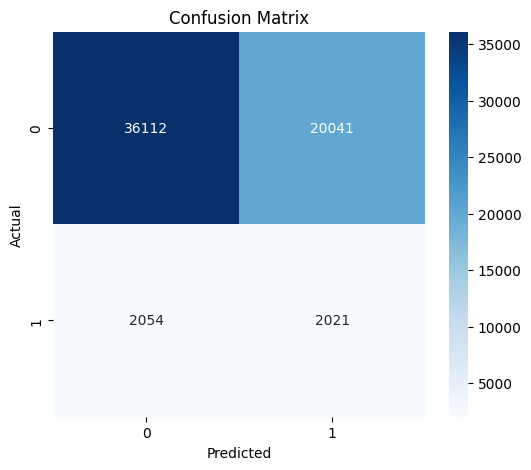


🔍 Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.64      0.77     56153
           1       0.09      0.50      0.15      4075

    accuracy                           0.63     60228
   macro avg       0.52      0.57      0.46     60228
weighted avg       0.89      0.63      0.72     60228



In [21]:

# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Compute F1 Score
f1 = f1_score(y_true, y_pred, average="weighted")  # Use "macro" for multi-class

print("📊 Confusion Matrix:\n", conf_matrix)
print(f"✅ F1 Score: {f1:.4f}")

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Print Detailed Classification Report
print("\n🔍 Classification Report:\n", classification_report(y_true, y_pred))


I noticed that there is a trade of between the FP to FN and TP , so I figured in areal world when ad is money (FP) and FN is amissed opprtunity there will be an expectation function for the cost and benfit that can maximize the profit thats when I tried to have a th as a cutoff for the probability instead of 0.5  

In [24]:
# Get prediction probabilities
y_pred_proba = model.predict_proba(X_test)

# Display confidence levels
print(y_pred_proba[:5])  # Show first 5 predictions


[[0.48745644 0.51254356]
 [0.28762478 0.7123752 ]
 [0.6382367  0.3617633 ]
 [0.42323387 0.57676613]
 [0.43709928 0.5629007 ]]


In [61]:
# Get prediction probabilities
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of class 1

# Apply threshold (Predict 1 only if probability > 0.6, else predict 0)
threshold = 0.56 #0.52 0.1574
y_pred_custom = (y_pred_proba > threshold).astype(int)
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_custom)
print("📊 Confusion Matrix:\n", conf_matrix)

# F1 Score
f1 = f1_score(y_true, y_pred_custom)
print(f"✅ F1 Score (with threshold 0.6): {f1:.4f}")
# Print Detailed Classification Report
print("\n🔍 Classification Report:\n", classification_report(y_true, y_pred_custom))

📊 Confusion Matrix:
 [[45163 10990]
 [ 2792  1283]]
✅ F1 Score (with threshold 0.6): 0.1570

🔍 Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.80      0.87     56153
           1       0.10      0.31      0.16      4075

    accuracy                           0.77     60228
   macro avg       0.52      0.56      0.51     60228
weighted avg       0.89      0.77      0.82     60228



In [22]:
# Save the model to a file
model.save_model("xgb_model_0.json")  # Saves as a JSON file



In [23]:
# Save predictions to CSV (No Header, No Index)
np.savetxt("predictions.csv", y_pred, delimiter=",", fmt="%d")

#Run for test2

In [6]:
new_df_train = load_dataframe_from_csv("train_preprocessed.csv")
new_df_test = load_dataframe_from_csv("/content/X_test_2nd.csv")
df_train_with_features, df_test_with_features = add_user_product_visit_counts(new_df_train, historical_df=new_df_test)
df_test_with_time_features = add_time_features(df_test_with_features)


✅ DataFrame loaded from 'train_preprocessed.csv'
✅ DataFrame loaded from '/content/X_test_2nd.csv'


In [11]:
test_data = df_test_with_time_features
training_data = df_train_with_features
training_data = training_data.copy().drop(columns=['session_id','DateTime','webpage_id','gender','age_level','product_category_2'])
test_data  = test_data.copy().drop(columns=['session_id','DateTime','webpage_id','gender','age_level','product_category_2'])


In [ ]:
y = training_data["is_click"]
X = training_data.drop(columns=["is_click"])

X_test = test_data.drop(columns=["is_click"])

In [14]:

# # Load the saved model
model = xgb.XGBClassifier()
model.load_model("xgb_model_0.json")

In [ ]:
X_test['product'] = X_test['product'].astype('category')
X_numeric = X_test.select_dtypes(include=['number'])  # Select only numerical columns
X_test[X_numeric.columns] = X_numeric.fillna(-999)  # Fill NaN only in numerical columns
y_pred = model.predict(X_test)

In [13]:
#Checking how many predictions of 1 I got
sum(y_pred),len(y_pred)

(22062, 60228)

In [16]:
# Get prediction probabilities
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of class 1

# Apply threshold (Predict 1 only if probability > 0.6, else predict 0)
threshold = 0.56 #0.52 0.1574
y_pred_custom = (y_pred_proba > threshold).astype(int)

In [25]:
y_pred_proba
np.savetxt("prob_yael.csv", y_pred_proba, delimiter=",", fmt="%f")

In [21]:

# Save to CSV (no header, no index)
np.savetxt("predictions_yael.csv", y_pred_custom, delimiter=",", fmt="%d")

print("✅ NumPy array saved to 'predictions.csv'.")


✅ NumPy array saved to 'predictions.csv'.


# Similarity

This is ideas for future implemntation doing similarity based on users demography and on product and having instead of users id's user groups reducing the space of the users

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity

# One-Hot Encode categorical features
encoder = OneHotEncoder(sparse=False)
df_encoded = encoder.fit_transform(df)

# Compute Cosine Similarity
similarity_matrix = cosine_similarity(df_encoded)
print(similarity_matrix)
